In [7]:
import xgboost as xgb
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [8]:
df = pd.read_csv("socal2(in).csv")
print(df.head())

   image_id                 street             citi  n_citi  bed  bath  sqft  \
0         0  1317 Van Buren Avenue  Salton City, CA     317    3   2.0  1560   
1         1         124 C Street W      Brawley, CA      48    3   2.0   713   
2         2        2304 Clark Road     Imperial, CA     152    3   1.0   800   
3         3     755 Brawley Avenue      Brawley, CA      48    3   1.0  1082   
4         4  2207 R Carrillo Court     Calexico, CA      55    4   3.0  2547   

    price  
0  201900  
1  228500  
2  273950  
3  350000  
4  385100  


In [9]:
# remove image_id
df.drop(columns=["image_id"], inplace=True)
print(df.head())

                  street             citi  n_citi  bed  bath  sqft   price
0  1317 Van Buren Avenue  Salton City, CA     317    3   2.0  1560  201900
1         124 C Street W      Brawley, CA      48    3   2.0   713  228500
2        2304 Clark Road     Imperial, CA     152    3   1.0   800  273950
3     755 Brawley Avenue      Brawley, CA      48    3   1.0  1082  350000
4  2207 R Carrillo Court     Calexico, CA      55    4   3.0  2547  385100


In [10]:
# seperate street number and street name form street
df[['street_number', 'street_name']] = df['street'].str.extract(r'(\d+)\s(.+)')
df.drop(columns=['street'], inplace=True)

# Group rare street names
top_streets = df["street_name"].value_counts().index[:10]  # Keep only top 10 most common streets
df["street_name"] = df["street_name"].apply(lambda x: x if x in top_streets else "Other")

print(df.head())
print(df.shape)  # (num_rows, num_columns)


              citi  n_citi  bed  bath  sqft   price street_number street_name
0  Salton City, CA     317    3   2.0  1560  201900          1317       Other
1      Brawley, CA      48    3   2.0   713  228500           124       Other
2     Imperial, CA     152    3   1.0   800  273950          2304       Other
3      Brawley, CA      48    3   1.0  1082  350000           755       Other
4     Calexico, CA      55    4   3.0  2547  385100          2207       Other
(15474, 8)


In [11]:
# prepare data
df["price"] = np.log1p(df["price"])
# **REMOVE OUTLIERS HERE (AFTER CLEANING, BEFORE TRAINING)**
# df = df[(df["price"] > df["price"].quantile(0.005)) & (df["price"] < df["price"].quantile(0.995))]

# **Add Interaction Features**
# df["bed_sqft"] = df["bed"] * df["sqft"]
# df["bath_sqft"] = df["bath"] * df["sqft"]

X = df.drop(columns=["price"])  # Features
y = df["price"]  # Target variable



#print("Columns in X_train:", X_train.columns)
#print("Data Types in X_train:", X_train.dtypes)



In [ ]:
from sklearn.preprocessing import OneHotEncoder
from category_encoders import TargetEncoder

# convert categorical columns into numerical values because XGBoost only works with numeric data
categorical_features = ["citi", "street_name"]
noncategorical_features = ["n_citi", "bed", "bath", "sqft"]

# target encoding
target_enc = TargetEncoder()
df[categorical_features] = target_enc.fit_transform(df[categorical_features], df["price"])

X = df[noncategorical_features + categorical_features]  # Features (numeric + encoded categorical)
y = df["price"]  # Target variable

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# one-hot encoding
"""
encoder = OneHotEncoder(sparse_output=False, drop="first")  # drop="first" to prevent multicollinearity
# Transform categorical features
encoded_features = encoder.fit_transform(X[categorical_features])
# Get column names after encoding
encoded_feature_names = encoder.get_feature_names_out(categorical_features)
# Convert to DataFrame
df_encoded = pd.DataFrame(encoded_features, columns=encoded_feature_names, index=X.index)
# Combine with numerical features
X_final = pd.concat([df_encoded, X[noncategorical_features]], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42)

print(X_train.shape)  # Number of features after encoding """



'\nencoder = OneHotEncoder(sparse_output=False, drop="first")  # drop="first" to prevent multicollinearity\n# Transform categorical features\nencoded_features = encoder.fit_transform(X[categorical_features])\n# Get column names after encoding\nencoded_feature_names = encoder.get_feature_names_out(categorical_features)\n# Convert to DataFrame\ndf_encoded = pd.DataFrame(encoded_features, columns=encoded_feature_names, index=X.index)\n# Combine with numerical features\nX_final = pd.concat([df_encoded, X[noncategorical_features]], axis=1)\n\nX_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42)\n\nprint(X_train.shape)  # Number of features after encoding '

In [13]:
#for col in ["citi", "street_number", "street_name"]:
    #X_train[col] = X_train[col].astype("category")
    #X_test[col] = X_test[col].astype("category")

# XGBoost regressor
"""xgb_model = xgb.XGBRegressor(
    n_estimators=500,  # Number of trees (higher = better but slower)
    learning_rate=0.05,  # Step size (lower = more accurate but slower)
    max_depth=7,  # Depth of each tree (higher = complex model)
    objective="reg:squarederror",  # For regression tasks
    random_state=42,
    #enable_categorical=True  # New feature in XGBoost
)"""

xgb_model = xgb.XGBRegressor(
    n_estimators=700,       # More trees for better learning
    learning_rate=0.05,     # Lower learning rate for stable training
    max_depth=7,            # Prevents excessive depth (overfitting)
    subsample=0.8,          # Uses 80% of data per tree (reduces variance)
    colsample_bytree=0.8,   # Uses 80% of features per tree (improves generalization)
    reg_lambda=1,           # L2 regularization (reduces overfitting)
    reg_alpha=0.1,          # L1 regularization (adds sparsity)
    gamma=0.1,              # Minimum loss reduction required for a split
    random_state=42
)

# train model
xgb_model.fit(X_train, y_train)



XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.1, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=700, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [14]:
# Make Predictions and Evaluate the Model

# Predict on test set
y_pred = xgb_model.predict(X_test)

# Convert back to actual price
# y_pred = np.expm1(y_pred_log)  # Reverse the log transformation
# y_test_actual = np.expm1(y_test)  # Convert test labels back

# Evaluate performance
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R² Score: {r2:.2f}")  # Measures how well model explains variance (closer to 1 is better)


Mean Absolute Error (MAE): 0.17
Mean Squared Error (MSE): 0.06
R² Score: 0.77


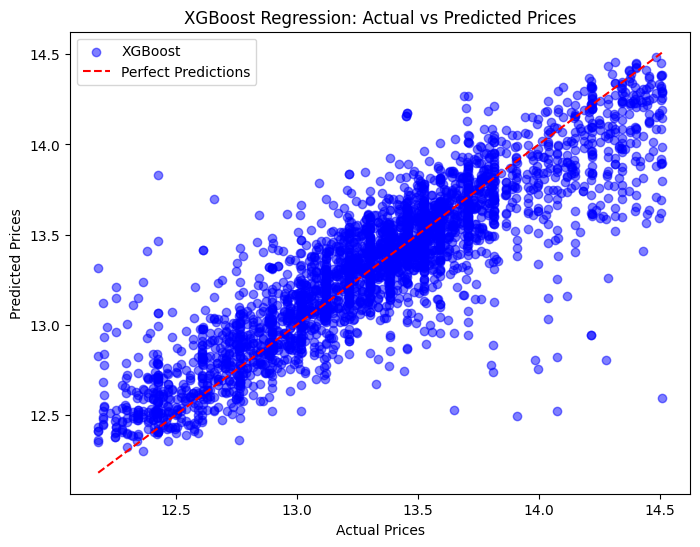

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Predict using XGBoost
y_pred_xgb = xgb_model.predict(X_test)

# Scatter plot
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred_xgb, alpha=0.5, color="blue", label="XGBoost")

# Add a diagonal line (perfect prediction reference)
x = np.linspace(min(y_test), max(y_test), 100)
plt.plot(x, x, color="red", linestyle="dashed", label="Perfect Predictions")

plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("XGBoost Regression: Actual vs Predicted Prices")
plt.legend()
plt.show()


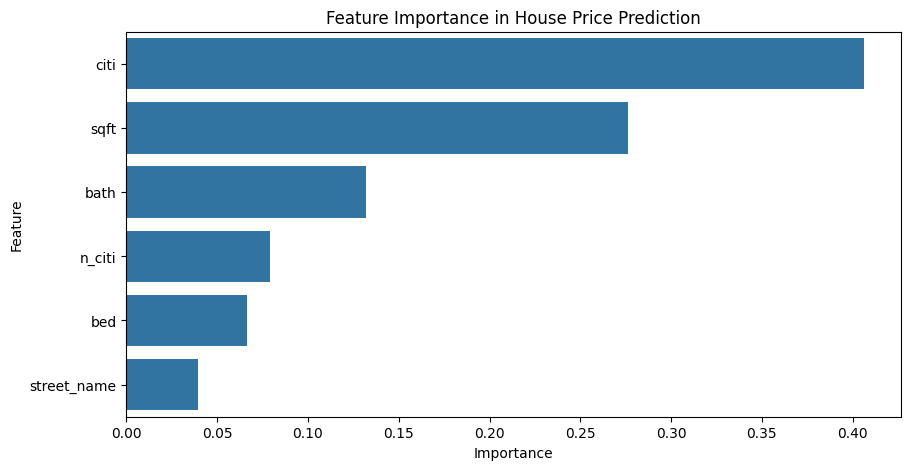

In [16]:
# Understand Which Factors Affect Prices Most

import matplotlib.pyplot as plt
import seaborn as sns

# Ensure we use the processed feature names from X_train
importance_df = pd.DataFrame({
    'Feature': X_train.columns,  # Use X_train.columns instead of X.columns
    'Importance': xgb_model.feature_importances_
})

# Sort by importance score
importance_df = importance_df.sort_values(by="Importance", ascending=False)

# Plot feature importance
plt.figure(figsize=(10,5))
sns.barplot(x=importance_df["Importance"], y=importance_df["Feature"])
plt.title("Feature Importance in House Price Prediction")
plt.show()



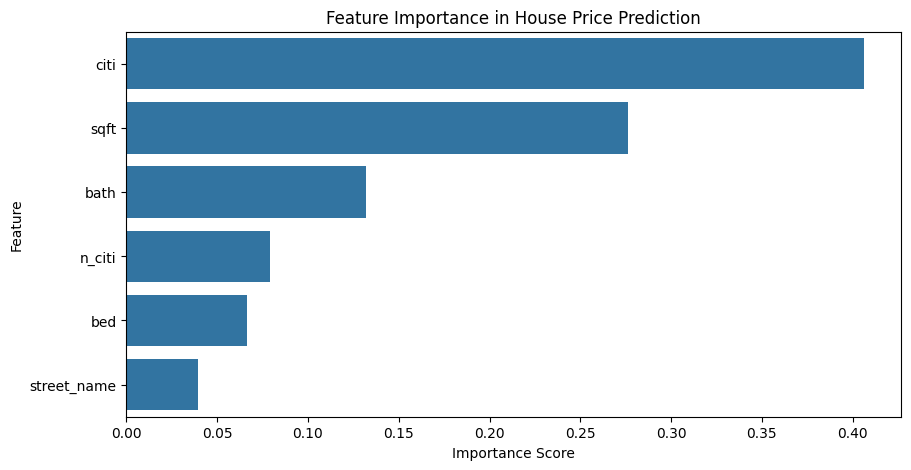

In [17]:


# Get feature importance scores
feature_importance = xgb_model.feature_importances_

# Create DataFrame for visualization
importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by="Importance", ascending=False)

# Plot feature importance
plt.figure(figsize=(10,5))
sns.barplot(x=importance_df["Importance"], y=importance_df["Feature"])
plt.title("Feature Importance in House Price Prediction")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()
